<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Text_generation_with_a_miniature_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
import os
import re
import string
import random

In [ ]:
def casual_attention_mask(batch_size, n_dest, n_src, dtype):
  i = tf.range(n_dest)[:, None]
  j = tf.range(n_src)
  m = i >=j - n_src + n_dest
  mask = tf.cast(m, dtype)
  mask = tf.reshape(mask, [1, n_dest, n_src])
  mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1,1], dtype=tf.int32)], 0)
  return tf.tile(mask, mult)


class TransformerBlock(layers.Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.1):
    super(TransformerBlock, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads, embed_dim)
    self.ffn = keras.Sequential([
                                 layers.Dense(ff_dim, activation='relu'),
                                 layers.Dense(embed_dim)
    ])
    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)

  def call(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size = input_shape[0]
    seq_len = input_shape[1]
    casual_mask = casual_attention_mask(batch_size, seq_len, seq_len, tf.bool)
    attention_output = self.att(inputs, inputs, attention_mask = casual_mask)
    attention_output = self.dropout1(attention_output)
    out1 = self.layernorm1(inputs + attention_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output)
    return self.layernorm2(out1 + ffn_output)


In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.token_emb = layers.Embedding(input_dim = vocab_size, output_dim= embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x):
    maxlen = tf.shape(x)[-1]
    positions = tf.range(start = 0, limit=maxlen, delta = 1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    return x + positions

In [ ]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 80  # Max sequence size
embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer

def create_model():
  inputs = layers.Input(shape = (maxlen, ), dtype=tf.int32)
  embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
  x = transformer_block(x)
  outputs = layers.Dense(vocab_size)(x)
  model = keras.Model(inputs = inputs, outputs = [outputs, x])
  
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile('adam', loss=[loss_fn, None])

  return model

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  10.3M      0  0:00:07  0:00:07 --:--:-- 17.6M


In [ ]:
batch_size = 128

filenames = []
directories = [
    "aclImdb/train/pos",
    "aclImdb/train/neg",
    "aclImdb/test/pos",
    "aclImdb/test/neg",   
]

for dir in directories:
  for f in os.listdir(dir):
    filenames.append(os.path.join(dir, f))

print(f"{len(filenames)} files")

random.shuffle(filenames)
text_ds = tf.data.TextLineDataset(filenames)
text_ds = text_ds.shuffle(buffer_size = 256)
text_ds = text_ds.batch(batch_size)


def custom_standardization(input_string):
  lowercased = tf.strings.lower(input_string)
  stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
  return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")

vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size -1,
    output_mode = 'int',
    output_sequence_length = maxlen +1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

def prepare_lm_inputs_labels(text):

  text = tf.expand_dims(text, -1)
  tokenized_sentences = vectorize_layer(text)
  x = tokenized_sentences[:, :-1]
  y = tokenized_sentences[:, 1:]
  return x, y

text_ds = text_ds.map(prepare_lm_inputs_labels)
text_ds = text_ds.prefetch(tf.data.experimental.AUTOTUNE)

50000 files


In [ ]:
a, b  = next(iter(text_ds))

In [ ]:
a

<tf.Tensor: shape=(128, 80), dtype=int64, numpy=
array([[   13,    22,    16, ...,     1,    29,  8113],
       [ 2169,  1433,     6, ..., 15364,     4,   205],
       [ 1267,    57,   103, ...,     1,    15,   113],
       ...,
       [   12,   431,   761, ..., 12821,    19,   159],
       [ 3971, 19814,    83, ...,  9248,     7,   130],
       [  116,    87,    44, ...,  7241,     3,   254]])>

In [ ]:
b

<tf.Tensor: shape=(128, 80), dtype=int64, numpy=
array([[   22,    16,    28, ...,    29,  8113,     4],
       [ 1433,     6,   380, ...,     4,   205,     4],
       [   57,   103,    20, ...,    15,   113,     9],
       ...,
       [  431,   761,    13, ...,    19,   159,   845],
       [19814,    83,     2, ...,     7,   130,    11],
       [   87,    44,    13, ...,     3,   254,    30]])>

In [ ]:
len(vocab)

19999

In [ ]:
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")


# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
  word_to_index[word] = index

start_prompt = "this movie is"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)


{'': 0,
 '[UNK]': 1,
 'the': 2,
 '.': 3,
 ',': 4,
 'a': 5,
 'and': 6,
 'of': 7,
 'to': 8,
 'is': 9,
 'it': 10,
 'in': 11,
 'i': 12,
 'this': 13,
 'that': 14,
 "'s": 15,
 'was': 16,
 'as': 17,
 'movie': 18,
 'with': 19,
 'for': 20,
 'but': 21,
 'film': 22,
 ')': 23,
 'you': 24,
 'on': 25,
 "'t": 26,
 '"': 27,
 'not': 28,
 'are': 29,
 'he': 30,
 'his': 31,
 'have': 32,
 'be': 33,
 'one': 34,
 '!': 35,
 'all': 36,
 'at': 37,
 'they': 38,
 'by': 39,
 'an': 40,
 'who': 41,
 'from': 42,
 'so': 43,
 'like': 44,
 '-': 45,
 'there': 46,
 'just': 47,
 'her': 48,
 'about': 49,
 'or': 50,
 'out': 51,
 'has': 52,
 'if': 53,
 '?': 54,
 'what': 55,
 'some': 56,
 'good': 57,
 'can': 58,
 'more': 59,
 'when': 60,
 'very': 61,
 'she': 62,
 'up': 63,
 'would': 64,
 'no': 65,
 'my': 66,
 'time': 67,
 'even': 68,
 'only': 69,
 'really': 70,
 'story': 71,
 'their': 72,
 'see': 73,
 'had': 74,
 'which': 75,
 'me': 76,
 'were': 77,
 'we': 78,
 'well': 79,
 "'": 80,
 'much': 81,
 'than': 82,
 ':': 83,
 'been':

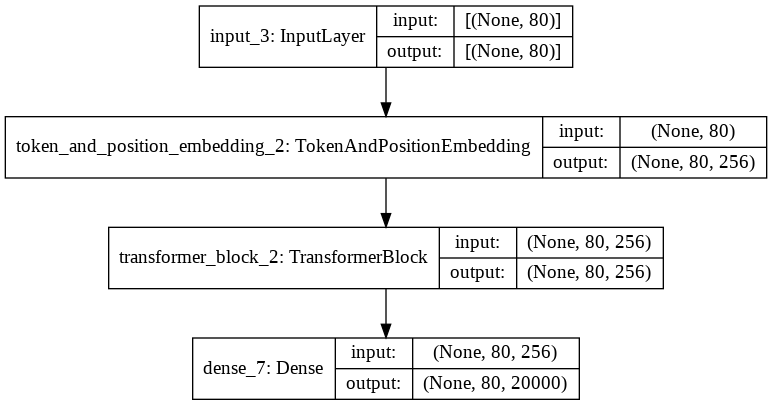

In [ ]:
model = create_model()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.fit(text_ds, verbose=2, epochs=25, callbacks=[text_gen_callback])


Epoch 1/25
391/391 - 135s - loss: 5.5446 - dense_7_loss: 5.5446
generated text:
this movie is really a movie . this film is about the story , but is that the story of the [UNK] " , in a movie with a lot of a lot of characters . . . . this movie is the movie

Epoch 2/25
391/391 - 133s - loss: 4.7117 - dense_7_loss: 4.7117
generated text:
this movie is a waste of time , and money to watch it again . the movie is a [UNK] [UNK] " . i don 't get the [UNK] ' . i have seen a very few times in the film is a little

Epoch 3/25
391/391 - 132s - loss: 4.4692 - dense_7_loss: 4.4692
generated text:
this movie is not a very good movie . it makes you feel like [UNK] . but if you want to watch the rest of the characters , and you will see the film if you have ever seen this movie , you are

Epoch 4/25
391/391 - 133s - loss: 4.3159 - dense_7_loss: 4.3159
generated text:
this movie is the kind of movie you can do not understand why it is not even a bad film , but it is not a compliment . but the film 's